In [6]:
#import some things we will need
import pandas as pd
import alipy

# Gather Photometric Zero Points
On 'Photometric' nights, the observer takes data of Landolt stars. The magnitude of these stars is very will known. We can use the observations of these stars to calibrate the true magnitude of other stars that were observed on the same night.

Eventually, we would like to calibrate the stars we will use as comparison stars in the Nova Musca field. To do this, we will first need the zero points which have been calculated from previous observations of Landolt Stars

In [7]:
#read in the zero points for a few months from 2012 into pandas data frames
augdeczp=pd.read_table('/home/ih64/Desktop/PhotResults/RESULTS.2012-08-12.txt',
                     sep='\s+',skiprows=1,names=['date', 'JulianDate', 'star',
                                      'b', 'v', 'r', 'i',
                                      'xb', 'xv', 'xr', 'xi',
                                      'cb', 'cv', 'cr', 'ci'])

In [8]:
#read in the zero points for different months from 2013 into pandas data frames
#the formatting is different for 2013. But it will be useful to have a mix
#of zero points from both years. Aug-Dec 2012 and Jan-May 2013 use different landolt stars
#using both to calibrate the nova musca field can help avoid any systematic errors
#associated with only 1 landolt field

janzp=pd.read_table('/home/ih64/Desktop/PhotResults/RESULTS.2013_01.txt',
                    skiprows=3,sep='\s+',names=['date','star','b','v','r','i',
                                                'cb','cv','cr','ci',
                                                'xb','xv','xr','xi'])

febzp=pd.read_table('/home/ih64/Desktop/PhotResults/RESULTS.2013_02.txt',
                    skiprows=3,sep='\s+',names=['date','star','b','v','r','i',
                                                'cb','cv','cr','ci',
                                                'xb','xv','xr','xi'])

marzp=pd.read_table('/home/ih64/Desktop/PhotResults/RESULTS.2013_03.txt',
                    skiprows=3,sep='\s+',names=['date','star','b','v','r','i',
                                                'cb','cv','cr','ci',
                                                'xb','xv','xr','xi'])

aprzp=pd.read_table('/home/ih64/Desktop/PhotResults/RESULTS.2013_04.txt',
                    skiprows=3,sep='\s+',names=['date','star','b','v','r','i',
                                                'cb','cv','cr','ci',
                                                'xb','xv','xr','xi'])

mayzp=pd.read_table('/home/ih64/Desktop/PhotResults/RESULTS.2013_05.txt',
                    skiprows=3,sep='\s+',names=['date','star','b','v','r','i',
                                                'cb','cv','cr','ci',
                                                'xb','xv','xr','xi'])

In [46]:
#now stack all the data frames into one data frame so we have all the data in one place
#doing the inner join gets rid of the 'juliandate' column in the augdec table. the other tables do not have this column

zpts=pd.concat([augdeczp,janzp,febzp,marzp,aprzp,mayzp], join='inner')

#now lets save this table
zpts.to_pickle('zptsTable')

# Align Nova Musca Images
In the I and V directories there are the respective I and V band observations of Nova Musca. We would like to make sure all these images are mutually aligned. This way it will be very easy to do aperature photometry in one shot on all of them.

I got all the Nova Musca images I could get my hands on. Some of them come from the directory /data/yalo180/yalo/SMARTS13m/CCD/ccdNovaMusca and the rest from /net/xrb/ccd/reduced. There are ~200 images for each band at this point. However, I had to go through and inspect images by eye to remove any weird-os. Some look like they have bad flat fielding, poor seeing, bad weather, or other anomolies. These were removed.

To align the images, we will rely on a package called 'alipy' someone else wrote. you can see the tutorial and learn more about alipy here http://obswww.unige.ch/~tewes/alipy/tutorial.html

In [13]:
#align the vband images. the reference image was chosen b.c. the seeing conditions were pretty good that night

import alipy
import glob

images_to_align = sorted(glob.glob("fitsimages/Vband/*.fits"))
ref_image = "fitsimages/Vband/rccd150205.0049.fits"

identifications = alipy.ident.run(ref_image, images_to_align, visu=False)
# That's it !
# Put visu=True to get visualizations in form of png files (nice but much slower)
# On multi-extension data, you will want to specify the hdu (see API doc).

# The output is a list of Identification objects, which contain the transforms :
for id in identifications: # list of the same length as images_to_align.
        if id.ok == True: # i.e., if it worked

                print "%20s : %20s, flux ratio %.2f" % (id.ukn.name, id.trans, id.medfluxratio)
                # id.trans is a alipy.star.SimpleTransform object. Instead of printing it out as a string,
                # you can directly access its parameters :
                #print id.trans.v # the raw data, [r*cos(theta)  r*sin(theta)  r*shift_x  r*shift_y]
                #print id.trans.matrixform()
                #print id.trans.inverse() # this returns a new SimpleTransform object

        else:
                print "%20s : no transformation found !" % (id.ukn.name)

# Minimal example of how to align images :

outputshape = alipy.align.shape(ref_image)
# This is simply a tuple (width, height)... you could specify any other shape.

for id in identifications:
        if id.ok == True:

                # Variant 1, using only scipy and the simple affine transorm :
                #alipy.align.affineremap(id.ukn.filepath, id.trans, shape=outputshape, makepng=True)

                # Variant 2, using geomap/gregister, correcting also for distortions :
                alipy.align.irafalign(id.ukn.filepath, id.uknmatchstars, id.refmatchstars, shape=outputshape, makepng=False)
                # id.uknmatchstars and id.refmatchstars are simply lists of corresponding Star objects.

                # By default, the aligned images are written into a directory "alipy_out".

# To be continued ..

##########  Preparing reference ...
No filter file found, using default filter
No NNW file found, using default NNW config
Number of sources in catalog : 924
EXT_NUMBER values found in catalog : 1
I've selected 851 sources
Making more quads, from quadlevel 0 ...
Made   35 quads from  500 stars (combi n=7 s=0 d=30.0)
Removing 0/35 duplicates
########## Processing fitsimages/Vband/rccd110402.0056.fits
No filter file found, using default filter
No NNW file found, using default NNW config
Number of sources in catalog : 1780
EXT_NUMBER values found in catalog : 1
I've selected 1157 sources
Making more quads, from quadlevel 0 ...
Made   35 quads from  500 stars (combi n=7 s=0 d=30.0)
Removing 0/35 duplicates
Finding 4 best candidates among 35 x 35 (ukn x ref)
We have a maximum of 35 quad pairs
Cand  1 (dist.   0.00030901) : Rotation   -0.049878 [deg], scale 1.000530
Cand  2 (dist.   0.00039367) : Rotation   -0.098520 [deg], scale 0.999941
Cand  3 (dist.   0.00057250) : Rotation   -0.143706 [

In [14]:
#align the iband images. the ref image was chosen bc the seeing was pretty good that night

images_to_align = sorted(glob.glob("fitsimages/Iband/*.fits"))
ref_image = "fitsimages/Iband/rccd150205.0048.fits"

identifications = alipy.ident.run(ref_image, images_to_align, visu=False)
# That's it !
# Put visu=True to get visualizations in form of png files (nice but much slower)
# On multi-extension data, you will want to specify the hdu (see API doc).

# The output is a list of Identification objects, which contain the transforms :
for id in identifications: # list of the same length as images_to_align.
        if id.ok == True: # i.e., if it worked

                print "%20s : %20s, flux ratio %.2f" % (id.ukn.name, id.trans, id.medfluxratio)
                # id.trans is a alipy.star.SimpleTransform object. Instead of printing it out as a string,
                # you can directly access its parameters :
                #print id.trans.v # the raw data, [r*cos(theta)  r*sin(theta)  r*shift_x  r*shift_y]
                #print id.trans.matrixform()
                #print id.trans.inverse() # this returns a new SimpleTransform object

        else:
                print "%20s : no transformation found !" % (id.ukn.name)

# Minimal example of how to align images :

outputshape = alipy.align.shape(ref_image)
# This is simply a tuple (width, height)... you could specify any other shape.

for id in identifications:
        if id.ok == True:

                # Variant 1, using only scipy and the simple affine transorm :
                #alipy.align.affineremap(id.ukn.filepath, id.trans, shape=outputshape, makepng=True)

                # Variant 2, using geomap/gregister, correcting also for distortions :
                alipy.align.irafalign(id.ukn.filepath, id.uknmatchstars, id.refmatchstars, shape=outputshape, makepng=False)
                # id.uknmatchstars and id.refmatchstars are simply lists of corresponding Star objects.

                # By default, the aligned images are written into a directory "alipy_out".

# To be continued ..

##########  Preparing reference ...
No filter file found, using default filter
No NNW file found, using default NNW config
Number of sources in catalog : 1207
EXT_NUMBER values found in catalog : 1
I've selected 1120 sources
Making more quads, from quadlevel 0 ...
Made   35 quads from  500 stars (combi n=7 s=0 d=30.0)
Removing 0/35 duplicates
########## Processing fitsimages/Iband/rccd110331.0053.fits
No filter file found, using default filter
No NNW file found, using default NNW config
Number of sources in catalog : 1756
EXT_NUMBER values found in catalog : 1
I've selected 1428 sources
Making more quads, from quadlevel 0 ...
Made   35 quads from  500 stars (combi n=7 s=0 d=30.0)
Removing 0/35 duplicates
Finding 4 best candidates among 35 x 35 (ukn x ref)
We have a maximum of 35 quad pairs
Cand  1 (dist.   0.00131990) : Rotation   -0.071343 [deg], scale 0.999925
Cand  2 (dist.   0.10887125) : Rotation  +50.909080 [deg], scale 1.500352
Cand  3 (dist.   0.11253521) : Rotation -167.156568

The aligning routine outputs the aligned images to the directory /home/ih64/NovaMusca/alipy_out. I renamed and moved the directories to /home/ih64/NovaMusca/fitsimages/Iband_aligned and /home/ih64/NovaMusca/fitsimages/Vband_aligned. There's some way to make it directly output to that path, but i didn't read through the documentation for this code to figure it out and just did it by hand. 

# Batch Photometry
now that our images are aligned, we can find the coordinates for the comparison stars on the finding chart, and use them to do aperture photometry quickly for all the images. I did this in IRAF, and try to keep an outline of the workflow below

cd /home/ih64/Desktop/NovaMusca/fitsimages/Iband_aligned

ecl>imexamine rccd150205.0049_gregister.fits logfile='coords.lis' keeplog+

*now the blinking cursor will appear over the image. hover the cursor over nova musc and press 'x' on the keyboard. this will mark the x,y pixel coordinates of the star in the file 'coords.lis' repeat for all comparison stars. when you are done, press q and the iraf prompt will return in your terminal and the blinking cursor will disaprear*

ecl>ls rccd*fits >> images.lis

ecl> epar phot

make sure you turn off interactive mode. use the settings susane describes here http://www.ctio.noao.edu/noao/content/13-m-smarts-photometric-calibrations-bvri

then do this process in the Vband_align directory too. you will have a bunch of .mag.1 files which have the photometry.

In [53]:
from astropy.io import ascii

magfiles=glob.glob('/home/ih64/Desktop/NovaMusca/fitsimages/Iband_align/rccd*.mag.1')
columns=['fname','date','juliandate','airmass',
         'mag1','mag2','mag3','mag4','mag5','mag6',
         'merr1','merr2','merr3','merr4','merr5','merr6']

rowdict={'fname':[],'date':[],'juliandate':[],'airmass':[],
         'mag1':[],'mag2':[],'mag3':[],'mag4':[],'mag5':[],'mag6':[],
         'merr1':[],'merr2':[],'merr3':[],'merr4':[],'merr5':[],'merr6':[]}
for i in magfiles:
    photdata=ascii.read(i)
    rowdict['fname'].append(photdata['IMAGE'][0])
    rowdict['date'].append(photdata['IMAGE'][0][4:10])
    rowdict['juliandate'].append(photdata['OTIME'][0])
    rowdict['airmass'].append(photdata['XAIRMASS'][0])
    rowdict['mag1'].append(photdata['MAG'][0])
    rowdict['mag2'].append(photdata['MAG'][1])
    rowdict['mag3'].append(photdata['MAG'][2])
    rowdict['mag4'].append(photdata['MAG'][3])
    rowdict['mag5'].append(photdata['MAG'][4])
    rowdict['mag6'].append(photdata['MAG'][5])
    rowdict['merr1'].append(photdata['MERR'][0])
    rowdict['merr2'].append(photdata['MERR'][1])
    rowdict['merr3'].append(photdata['MERR'][2])
    rowdict['merr4'].append(photdata['MERR'][3])
    rowdict['merr5'].append(photdata['MERR'][4])
    rowdict['merr6'].append(photdata['MERR'][5])

In [71]:
photITable=pd.DataFrame({'fname':rowdict['fname'],
                        'date':rowdict['date'],
                        'juliandate':rowdict['juliandate'],
                        'airmass':rowdict['airmass'],
                        'mag1':rowdict['mag1'],
                        'mag2':rowdict['mag2'],
                        'mag3':rowdict['mag3'],
                        'mag4':rowdict['mag4'],
                        'mag5':rowdict['mag5'],
                        'mag6':rowdict['mag6'],
                        'merr1':rowdict['merr1'],
                        'merr2':rowdict['merr2'],
                        'merr3':rowdict['merr3'],
                        'merr4':rowdict['merr4'],
                        'merr5':rowdict['merr5'],
                        'merr6':rowdict['merr6']})

In [79]:
#after doing some work, I figured out there are some cosmic rays in the aperature for images rccd110514.0042_gregist.fits
#and rccd140403.0054_gregist.fits. drop these rows from the table
photITable=photITable.drop(photITable.index[[122,11]])
#now lets save this table
photITable.to_pickle('photITable')

In [56]:
#same thing for V band
magfiles=glob.glob('/home/ih64/Desktop/NovaMusca/fitsimages/Vband_align/rccd*.mag.1')
columns=['fname','date','juliandate','airmass',
         'mag1','mag2','mag3','mag4','mag5','mag6',
         'merr1','merr2','merr3','merr4','merr5','merr6']

rowdict={'fname':[],'date':[],'juliandate':[],'airmass':[],
         'mag1':[],'mag2':[],'mag3':[],'mag4':[],'mag5':[],'mag6':[],
         'merr1':[],'merr2':[],'merr3':[],'merr4':[],'merr5':[],'merr6':[]}
for i in magfiles:
    photdata=ascii.read(i)
    rowdict['fname'].append(photdata['IMAGE'][0])
    rowdict['date'].append(photdata['IMAGE'][0][4:10])
    rowdict['juliandate'].append(photdata['OTIME'][0])
    rowdict['airmass'].append(photdata['XAIRMASS'][0])
    rowdict['mag1'].append(photdata['MAG'][0])
    rowdict['mag2'].append(photdata['MAG'][1])
    rowdict['mag3'].append(photdata['MAG'][2])
    rowdict['mag4'].append(photdata['MAG'][3])
    rowdict['mag5'].append(photdata['MAG'][4])
    rowdict['mag6'].append(photdata['MAG'][5])
    rowdict['merr1'].append(photdata['MERR'][0])
    rowdict['merr2'].append(photdata['MERR'][1])
    rowdict['merr3'].append(photdata['MERR'][2])
    rowdict['merr4'].append(photdata['MERR'][3])
    rowdict['merr5'].append(photdata['MERR'][4])
    rowdict['merr6'].append(photdata['MERR'][5])

In [57]:
photVTable=pd.DataFrame({'fname':rowdict['fname'],
                        'date':rowdict['date'],
                        'juliandate':rowdict['juliandate'],
                        'airmass':rowdict['airmass'],
                        'mag1':rowdict['mag1'],
                        'mag2':rowdict['mag2'],
                        'mag3':rowdict['mag3'],
                        'mag4':rowdict['mag4'],
                        'mag5':rowdict['mag5'],
                        'mag6':rowdict['mag6'],
                        'merr1':rowdict['merr1'],
                        'merr2':rowdict['merr2'],
                        'merr3':rowdict['merr3'],
                        'merr4':rowdict['merr4'],
                        'merr5':rowdict['merr5'],
                        'merr6':rowdict['merr6']})

In [73]:
#now lets save this table
photVTable.to_pickle('photVTable')

In [64]:
a=photITable['mag1']/photITable['mag3']
a.sort()

In [65]:
a

122    1.099126
11     1.101475
98     1.143657
21     1.144479
20     1.145092
25     1.146695
37     1.146725
19     1.147623
17     1.147639
131    1.148315
24     1.149167
10     1.149383
8      1.149391
9      1.149746
3      1.150091
...
4      1.177601
111    1.177768
51     1.178007
144    1.178930
95     1.182025
50     1.185056
53     1.186213
89     1.186505
88     1.186688
55     1.187200
84     1.188100
70     1.188332
79     1.192621
71     1.194997
54     1.195047
Length: 156, dtype: float64

In [113]:
photITable.ix[:,'merr1':].describe()

,merr1,merr3,merr4,merr5
count,144.000000,144.000000,144.000000,144.000000
mean,0.091604,0.003299,0.004736,0.020437
std,0.072467,0.001487,0.002241,0.010471
min,0.022000,0.002000,0.002000,0.010000
25%,0.054000,0.002000,0.003000,0.014000
50%,0.070000,0.003000,0.004000,0.016000
75%,0.104250,0.004000,0.005000,0.024000
max,0.579000,0.010000,0.016000,0.063000


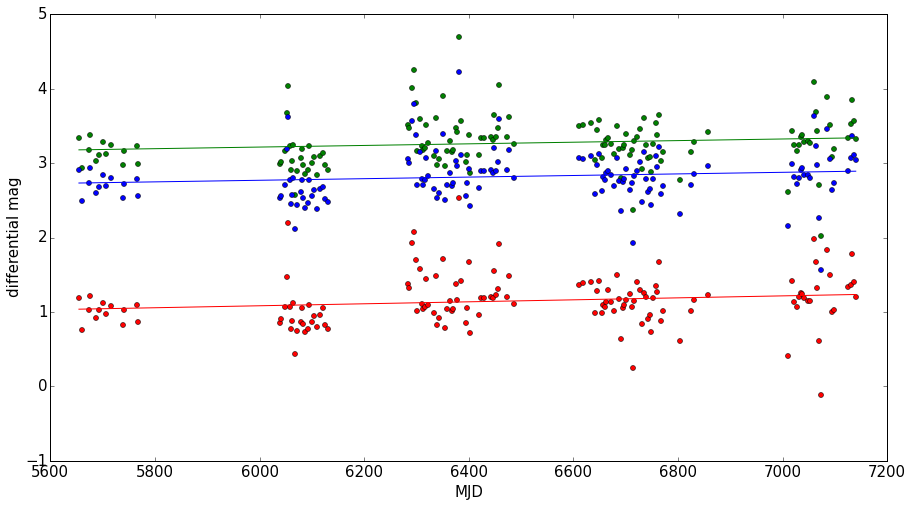

In [136]:
from sklearn import linear_model

regmag3=linear_model.LinearRegression()
regmag4=linear_model.LinearRegression()
regmag5=linear_model.LinearRegression()

regmag3.fit(photITable['juliandate'].values.reshape(-1,1),(photITable['mag1']-photITable['mag3']).values.reshape(-1,1))
regmag4.fit(photITable['juliandate'].values.reshape(-1,1),(photITable['mag1']-photITable['mag4']).values.reshape(-1,1))
regmag5.fit(photITable['juliandate'].values.reshape(-1,1),(photITable['mag1']-photITable['mag5']).values.reshape(-1,1))

fig=plt.figure(figsize=(15,8))
ax=fig.add_subplot(111)

ax.plot(photITable['juliandate'].values.astype(float)-2450000,photITable['mag1']-photITable['mag3'],'go',ms=5)
ax.plot(photITable['juliandate'].values.astype(float)-2450000,photITable['mag1']-photITable['mag4'],'bo',ms=5)
ax.plot(photITable['juliandate'].values.astype(float)-2450000,photITable['mag1']-photITable['mag5'],'ro',ms=5)

ax.plot(photITable['juliandate'].values.astype(float)-2450000,regmag3.predict(photITable['juliandate'].values.reshape(-1,1).astype(float)),color='green')
ax.plot(photITable['juliandate'].values.astype(float)-2450000,regmag4.predict(photITable['juliandate'].values.reshape(-1,1).astype(float)),color='blue')
ax.plot(photITable['juliandate'].values.astype(float)-2450000,regmag5.predict(photITable['juliandate'].values.reshape(-1,1).astype(float)),color='red')

ax.set_xlabel('MJD')
ax.set_ylabel('differential mag')

for i in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    i.set_fontsize(15)

plt.show()

In [145]:
regmag3.predict(photITable['juliandate'].values.astype(float).reshape(-1,1)[0])

array([ 3.17943522])

In [146]:
regmag3.predict(photITable['juliandate'].values.astype(float).reshape(-1,1)[-1])

array([ 3.34059727])

In [140]:
regmag5.coef_*365

array([[ 0.04855461]])

In [120]:
len(photITable['mag1']/photITable['mag3'])

144

In [147]:
3.34059727-3.17943522

0.16116205000000017